### Weight pruning 하기

* 가중치의 일부를 0으로 바꿔서 모델 크기를 줄이는 방법
* 모델에 구조적인 변화를 주는 것은 아니므로 Unstructured Pruning 이라고 불린다.
* 직접적으로 구조를 변경하는 방법으로는 Structured Pruning이 존재한다.

* 목표 : Graph 만들기
    * x축 : pruning 정도를 나타냄 (%)
    * y축 : testset accuracy (trainset accuracy)

### 절차
1. 먼저 학습된 모델이 필요하므로 CIFAR-10에 대해서 학습
2. 학습된 모델에서 일부 가중치를 0으로 만듬
3. pruned model을 이용하여 training-set과 test-set에 대한 정확도를 구함
4. pruning 하는 정도를 점차 증가시키며 정확도 추이를 확인한다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import glob
import PIL
from PIL import Image
from torch.utils import data as D
from torch.utils.data.sampler import SubsetRandomSampler
import random
import torchsummary

print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu102
cuda:0


In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))

random_seed = 42
np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split] # train 90% valid 10%로 설정
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, sampler=valid_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print("# of train set :", int(len(trainset) * 0.9))
print("# of valid set :", int(len(validset) * 0.1))
print("# of test set :", len(testset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
# of train set : 45000
# of valid set : 5000
# of test set : 10000


In [5]:
print(trainset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of the image:  torch.Size([3, 274, 274])


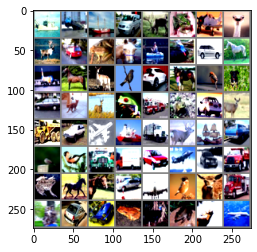

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of the image:  torch.Size([3, 32, 32])


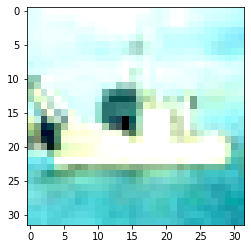

ship


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    print("shape of the image: ", img.shape)
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# 학습용 이미지 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

imshow(images[0])
print(trainset.classes[labels[0]])

In [11]:
# 모델 불러오기
from densenet import DenseNet

In [16]:
def DenseNetBC_100_12():
    return DenseNet(growth_rate=12, num_layers=100, theta=0.5, drop_rate=0.2, num_classes=10)

print(device)
model = DenseNetBC_100_12()
model = model.to(device)


cuda:0


In [17]:
PATH = './cifar_net.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [21]:
correct = 0
total = 0

# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없다.
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).to(device)
    
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
    print('Accuracy of the network on the 10000 test images : %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images : 86 %


# pruning 적용하기

In [159]:
state_dict = model.state_dict()

with torch.no_grad():
    for name, param in model.named_parameters():
        print(name)
        # 파라미터를 직렬화하고 난 후에 원하는 비율 만큼 삭제해야함
        # 삭제 기준은 절대값이 작은 순서대로 버리도록 함
        # print(torch.argsort(param.view(-1), descending=True))

        # 비율 정하기
        alpha = 0.7   # 삭제할 파라미터 비율
        max_idx = int(len(list(param.view(-1))) * alpha)
        mask = torch.argsort(torch.abs(param.view(-1))).ge(max_idx)
        new_param = torch.reshape(param.view(-1) * mask, tuple(param.shape))
        
        param.copy_(new_param)

dense_init.weight
dense_init.bias
dense_block_1.bottleneck_layer_0.conv_1x1.batch_norm.weight
dense_block_1.bottleneck_layer_0.conv_1x1.batch_norm.bias
dense_block_1.bottleneck_layer_0.conv_1x1.conv.weight
dense_block_1.bottleneck_layer_0.conv_3x3.batch_norm.weight
dense_block_1.bottleneck_layer_0.conv_3x3.batch_norm.bias
dense_block_1.bottleneck_layer_0.conv_3x3.conv.weight
dense_block_1.bottleneck_layer_1.conv_1x1.batch_norm.weight
dense_block_1.bottleneck_layer_1.conv_1x1.batch_norm.bias
dense_block_1.bottleneck_layer_1.conv_1x1.conv.weight
dense_block_1.bottleneck_layer_1.conv_3x3.batch_norm.weight
dense_block_1.bottleneck_layer_1.conv_3x3.batch_norm.bias
dense_block_1.bottleneck_layer_1.conv_3x3.conv.weight
dense_block_1.bottleneck_layer_2.conv_1x1.batch_norm.weight
dense_block_1.bottleneck_layer_2.conv_1x1.batch_norm.bias
dense_block_1.bottleneck_layer_2.conv_1x1.conv.weight
dense_block_1.bottleneck_layer_2.conv_3x3.batch_norm.weight
dense_block_1.bottleneck_layer_2.conv_3x3.batc

dense_block_2.bottleneck_layer_12.conv_1x1.batch_norm.bias
dense_block_2.bottleneck_layer_12.conv_1x1.conv.weight
dense_block_2.bottleneck_layer_12.conv_3x3.batch_norm.weight
dense_block_2.bottleneck_layer_12.conv_3x3.batch_norm.bias
dense_block_2.bottleneck_layer_12.conv_3x3.conv.weight
dense_block_2.bottleneck_layer_13.conv_1x1.batch_norm.weight
dense_block_2.bottleneck_layer_13.conv_1x1.batch_norm.bias
dense_block_2.bottleneck_layer_13.conv_1x1.conv.weight
dense_block_2.bottleneck_layer_13.conv_3x3.batch_norm.weight
dense_block_2.bottleneck_layer_13.conv_3x3.batch_norm.bias
dense_block_2.bottleneck_layer_13.conv_3x3.conv.weight
dense_block_2.bottleneck_layer_14.conv_1x1.batch_norm.weight
dense_block_2.bottleneck_layer_14.conv_1x1.batch_norm.bias
dense_block_2.bottleneck_layer_14.conv_1x1.conv.weight
dense_block_2.bottleneck_layer_14.conv_3x3.batch_norm.weight
dense_block_2.bottleneck_layer_14.conv_3x3.batch_norm.bias
dense_block_2.bottleneck_layer_14.conv_3x3.conv.weight
dense_block

In [161]:
correct = 0
total = 0

# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없다.
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).to(device)
    
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
    print('Accuracy of the network on the 10000 test images : %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images : 9 %


In [122]:
a = torch.Tensor([1, 2, 3, 4, 5, 6, 7 ,8, 9, 10, -11, -12, -13, -14 ,-15])
print(a)

tensor([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10., -11., -12.,
        -13., -14., -15.])


In [127]:
b = torch.Tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [137]:
alpha = 0.7

delete_idx = int(len(list(b.view(-1))) * alpha)
print(delete_idx)

6


In [145]:
torch.abs(b)

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [146]:
mask = torch.argsort(torch.abs(b.view(-1))).ge(delete_idx)

In [151]:
b = torch.reshape(b.view(-1) * mask, tuple(b.shape))

In [152]:
print(b)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [7., 8., 9.]])
